In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
dataset = pd.read_csv("C:\\Users\Maurice\\Documents\\QML\\CIC-IDS2017-MLCSV\\MachineLearningCVE\\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")


# Remove leading/trailing spaces from column names
dataset.columns = dataset.columns.str.strip()
# Replace infinities with NaN
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values with the mode (most frequent value) for categorical columns
dataset['Label'] = dataset['Label'].fillna(dataset['Label'].mode()[0])

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
dataset['Label'] = label_encoder.fit_transform(dataset['Label'])

# Verify that there are no missing values
print(dataset.isnull().sum())  # Should print 0 for all columns

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64


In [3]:
# Define sample size
n_samples = 500

# Select only numeric features
df_numeric = dataset.select_dtypes(include=['number'])

# Ensure there are at least 64 features
if df_numeric.shape[1] < 64:
    raise ValueError("Dataset has fewer than 64 numeric features. Consider feature engineering or PCA.")

# Randomly sample 200 rows while maintaining class balance
df_sampled = dataset.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples // dataset['Label'].nunique()), random_state=42))

# Drop non-numeric columns (if any)
df_sampled = df_sampled.select_dtypes(include=['number']).reset_index(drop=True)

C:\Users\Maurice\AppData\Local\Temp\ipykernel_13440\2294693954.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = dataset.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples // dataset['Label'].nunique()), random_state=42))


In [4]:
# Select the features (numeric columns) and labels
X = df_sampled.drop(columns=['Label'])

from sklearn.preprocessing import MinMaxScaler

X= pd.DataFrame(X, columns=X.columns)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Encode the labels as integers
y = df_sampled['Label'].factorize()[0]  # Converts the string labels to integer labels


# Check the shape of the data
print(X.shape, y.shape)

(500, 78) (500,)


Training original model...

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc
---------------------------------------------------------------------------
    0 | 0.1661 | 0.8575 | 0.0167 | 0.9836 | 0.0170 | 0.9833
    1 | 0.1145 | 0.8973 | 0.0164 | 0.9839 | 0.0166 | 0.9837
    2 | 0.0801 | 0.9259 | 0.0173 | 0.9830 | 0.0164 | 0.9839
    3 | 0.0577 | 0.9455 | 0.0170 | 0.9833 | 0.0169 | 0.9834
    4 | 0.0425 | 0.9592 | 0.0170 | 0.9833 | 0.0170 | 0.9832
    5 | 0.0327 | 0.9684 | 0.0173 | 0.9830 | 0.0176 | 0.9827
    6 | 0.0274 | 0.9733 | 0.0182 | 0.9821 | 0.0188 | 0.9816
    7 | 0.0245 | 0.9761 | 0.0192 | 0.9811 | 0.0198 | 0.9806
    8 | 0.0229 | 0.9776 | 0.0200 | 0.9804 | 0.0205 | 0.9799
    9 | 0.0217 | 0.9788 | 0.0207 | 0.9797 | 0.0209 | 0.9795
   10 | 0.0218 | 0.9787 | 0.0212 | 0.9792 | 0.0213 | 0.9791
   11 | 0.0217 | 0.9787 | 0.0217 | 0.9788 | 0.0216 | 0.9788

Early stopping triggered!

Evaluating original model...

Applying pruning...
Prun

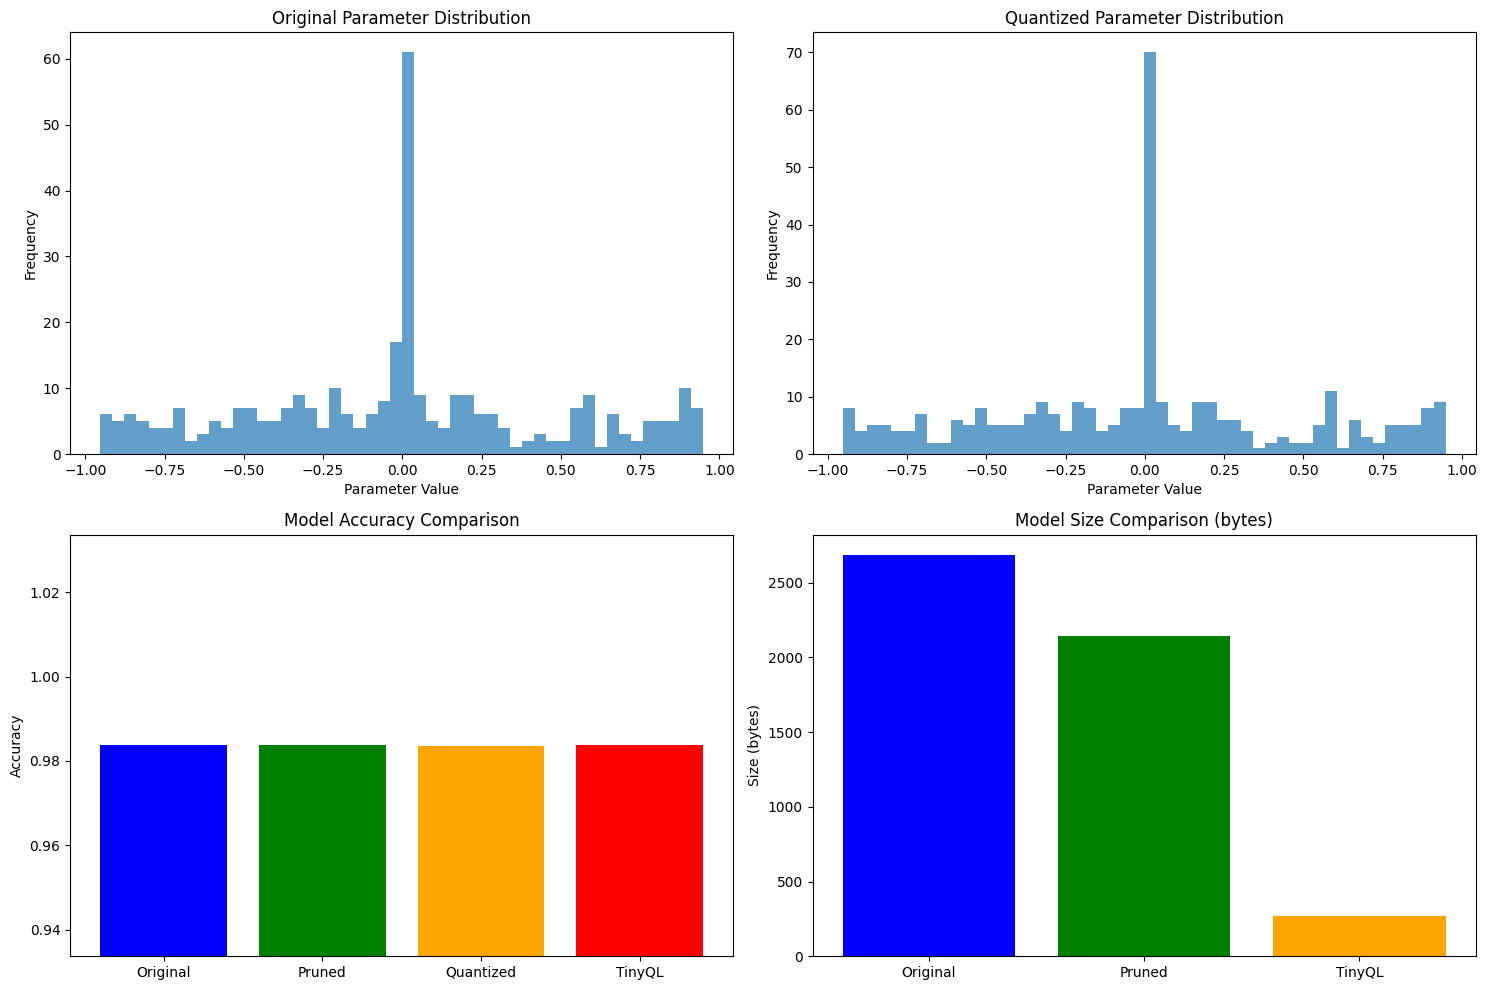

In [5]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()
        
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper Hermitian handling"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Use top eigenvectors with proper normalization
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices]
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Combine eigenvectors
        latent_state = np.zeros(dim, dtype=complex)
        for w, i in zip(weights, top_indices):
            latent_state += np.sqrt(w) * eigenvecs[:, i]
            
        # Ensure proper normalization
        latent_state = latent_state / np.linalg.norm(latent_state)
        return latent_state
        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def apply_quantization(self, bits=8):
        """
        Quantize parameters to specified bit precision
        Returns the original and quantized parameters for comparison
        """
        original_params = self.params.copy()
        
        # Find min and max for scaling
        p_min, p_max = np.min(self.params), np.max(self.params)
        
        # Scale to [0, 2^bits - 1]
        scale = (2**bits - 1) / (p_max - p_min)
        
        # Quantize
        quantized_int = np.round((self.params - p_min) * scale)
        
        # Scale back to original range
        self.params = (quantized_int / scale) + p_min
        
        # Apply pruning mask to ensure quantized pruned values stay at zero
        self.params = self.params * self.pruning_mask
        
        return original_params, self.params

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def evaluate_model(model, X_test):
    """Evaluate model on test data and return accuracy"""
    losses = []
    with torch.no_grad():
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            loss = np.mean((decoded[:len(x)] - x)**2)
            losses.append(loss)
    
    test_loss = np.mean(losses)
    test_accuracy = 1 / (1 + test_loss)
    return test_loss, test_accuracy

def train_model(X, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for quantum autoencoder"""
    set_seeds(seed)
    
    # Use the provided X dataset
    # Split data into train, validation, and test sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)  # 15%/15% val/test split
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # For 78 features, we need 7 qubits (2^6 = 64 < 78 < 2^7 = 128)
    n_qubits = 7
    latent_qubits = 5  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': [], 'test_losses':[], 'test_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            # Initialize batch loss properly for accumulation
            batch_loss = 0.0
            
            for x in batch_data:
                # Convert input to tensor
                x_tensor = torch.tensor(x, dtype=torch.float64)
                
                # Forward pass
                decoded = model.forward(x)
                
                # Ensure decoded is a tensor with proper type
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                # Calculate individual sample loss
                # Only compare against original dimensions
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                
                # Accumulate loss (without requiring grad)
                batch_loss += reconstruction_loss.item()
            
            # Calculate average reconstruction loss for the batch
            avg_recon_loss = batch_loss / len(batch_data)
            
            # Add L2 regularization directly to the final loss calculation
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            # Backward pass on the properly constructed loss
            final_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Record loss for this batch
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        
        # Evaluate on test set
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)

        test_loss = np.mean(test_losses)
        test_accuracy = 1 / (1 + test_loss)
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)

        metrics['test_losses'].append(test_loss)
        metrics['test_accuracies'].append(test_accuracy)
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f} | {test_loss:.4f} | {test_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.998 and train_accuracy >= 0.998:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics, X_test

def compare_models(X, seed=42):
    """Train and compare original, pruned, and quantized models"""
    set_seeds(seed)
    
    # # Create synthetic dataset if needed
    # if X is None:
    #     X, _ = make_classification(n_samples=200, n_features=78, random_state=seed)
    
    # Train original model
    print("Training original model...")
    original_model, _, _, X_test = train_model(X, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_loss, original_accuracy = evaluate_model(original_model, X_test)
    
    # Create pruned model (clone from original)
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Apply pruning (prune 20% of smallest magnitude parameters)
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    pruned_loss, pruned_accuracy = evaluate_model(pruned_model, X_test)
    
    # Create quantized model (clone from pruned)
    print("\nApplying quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    
    # Apply 8-bit quantization
    original_params, quantized_params = quantized_model.apply_quantization(bits=8)
    
    # Evaluate quantized model
    quantized_loss, quantized_accuracy = evaluate_model(quantized_model, X_test)
    
    # Fine-tune quantized model
    print("\nTinyQL model creation ...")
    # Convert params to tensor for fine-tuning
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)  # Lower learning rate for fine-tuning
    
    # Preprocess data
    X_train, _ = train_test_split(X, test_size=0.3, random_state=seed)
    X_train = preprocess_data(X_train)
    
    # Fine-tuning loop (shorter)
    for epoch in range(20):
        # Apply params to model
        quantized_model.params = params.detach().numpy()
        
        # Batch processing
        batch_idx = np.random.choice(len(X_train), min(8, len(X_train)))
        batch_data = X_train[batch_idx]
        
        # Process batch
        optimizer.zero_grad()
        
        # Track loss as a tensor with gradients
        batch_loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)
        
        for i, x in enumerate(batch_data):
            x_tensor = torch.tensor(x, dtype=torch.float64)
            
            # Set model parameters for this forward pass
            quantized_model.params = params.detach().numpy()
            
            # Forward pass
            decoded = quantized_model.forward(x)
            
            # Ensure decoded is a tensor with proper type
            if not torch.is_tensor(decoded):
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64)
            elif decoded.dtype != torch.float64:
                decoded = decoded.real.to(torch.float64)
            
            # Calculate MSE loss with gradients attached
            if i == 0:
                # For the first sample, create a loss tensor with gradients
                batch_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
            else:
                # For subsequent samples, accumulate loss
                batch_loss = batch_loss + torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
        
        # Calculate average loss
        avg_loss = batch_loss / len(batch_data)
        
        # Add L2 regularization
        final_loss = avg_loss + 0.001 * torch.sum(params**2)
        
        # Backward and optimize
        final_loss.backward()
        optimizer.step()
        
        # Re-quantize after gradient update
        quantized_model.params = params.detach().numpy()
        _, quantized_model.params = quantized_model.apply_quantization(bits=8)
        params.data = torch.tensor(quantized_model.params)
        
        # Keep pruned parameters at zero
        quantized_model.params = quantized_model.params * quantized_model.pruning_mask
        params.data = torch.tensor(quantized_model.params)
        
        if (epoch + 1) % 5 == 0:
            try:
                print(f"Fine-tuning epoch {epoch+1}, Loss: {final_loss.item():.6f}")
            except:
                print(f"Fine-tuning epoch {epoch+1}, Loss calculation failed but training continues")
    
    # Final evaluation of fine-tuned quantized model
    finetuned_loss, finetuned_accuracy = evaluate_model(quantized_model, X_test)
    
    # Calculate compression metrics
    param_count = len(original_model.params)
    original_size = param_count * 64  # 64-bit floating point (8 bytes)
    pruned_size = np.sum(pruned_model.pruning_mask) * 64  # Only non-pruned params
    quantized_size = np.sum(quantized_model.pruning_mask) * 8  # 8-bit quantized non-pruned params
    compression_ratio = original_size / quantized_size
    
    # Print results
    print("\n" + "="*50)
    print("MODEL COMPARISON RESULTS")
    print("="*50)
    print(f"Original Model Accuracy:       {original_accuracy:.6f}")
    print(f"Pruned Model Accuracy:         {pruned_accuracy:.6f}")
    print(f"TinyQL Model Accuracy:      {quantized_accuracy:.6f}")
    print(f"Fine-tuned Quantized Accuracy: {finetuned_accuracy:.6f}")
    print("-"*50)
    print(f"Original Size:        {original_size/8:.1f} bytes (100.0%)")
    print(f"After Pruning:        {pruned_size/8:.1f} bytes ({pruned_size/original_size*100:.1f}%)")
    print(f"After Quantization:   {quantized_size/8:.1f} bytes ({quantized_size/original_size*100:.1f}%)")
    print(f"Compression Ratio:    {compression_ratio:.2f}x")
    print(f"Accuracy Change:      {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%")
    
    # Plot parameter distribution before and after quantization
    plt.figure(figsize=(15, 10))
    
    # Original parameters histogram
    plt.subplot(2, 2, 1)
    plt.hist(original_params.flatten(), bins=50, alpha=0.7)
    plt.title("Original Parameter Distribution")
    plt.xlabel("Parameter Value")
    plt.ylabel("Frequency")
    
    # Quantized parameters histogram
    plt.subplot(2, 2, 2)
    plt.hist(quantized_params.flatten(), bins=50, alpha=0.7)
    plt.title("Quantized Parameter Distribution")
    plt.xlabel("Parameter Value")
    plt.ylabel("Frequency")
    
    # Accuracy comparison
    plt.subplot(2, 2, 3)
    models = ["Original", "Pruned", "Quantized", "TinyQL"]
    accuracies = [original_accuracy, pruned_accuracy, quantized_accuracy, finetuned_accuracy]
    plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
    plt.ylim(min(accuracies) - 0.05, max(accuracies) + 0.05)
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    
    # Size comparison
    plt.subplot(2, 2, 4)
    sizes = [original_size/8, pruned_size/8, quantized_size/8]
    size_labels = ["Original", "Pruned", "TinyQL"]
    plt.bar(size_labels, sizes, color=['blue', 'green', 'orange'])
    plt.title("Model Size Comparison (bytes)")
    plt.ylabel("Size (bytes)")
    
    plt.tight_layout()
    plt.savefig("quantum_model_comparison.png")
    
    return {
        "original_accuracy": original_accuracy,
        "pruned_accuracy": pruned_accuracy, 
        "quantized_accuracy": quantized_accuracy,
        "finetuned_accuracy": finetuned_accuracy,
        "compression_ratio": compression_ratio,
        "pruning_percentage": pruning_percentage
    }

# # Generate synthetic data for testing if needed
# def generate_synthetic_data(n_samples=200, n_features=78, seed=42):
#     set_seeds(seed)
#     X, _ = make_classification(n_samples=n_samples, n_features=n_features, random_state=seed)
#     return X

if __name__ == "__main__":
    # To use synthetic data, uncomment this line:
    # X = generate_synthetic_data()
    
    # For real data, make sure X is defined
    # X = ...  # Your data with approx 78 features
    
    # Compare models and get results
    results = compare_models(X)
    
    # Print summary
    print("\nSUMMARY:")
    print(f"Original model accuracy: {results['original_accuracy']:.6f}")
    print(f"Final model accuracy: {results['finetuned_accuracy']:.6f}")
    print(f"Compression ratio: {results['compression_ratio']:.2f}x")
    print(f"Accuracy impact: {(results['finetuned_accuracy']-results['original_accuracy'])/results['original_accuracy']*100:.2f}%")

Training original model...

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc
---------------------------------------------------------------------------
    0 | 0.1661 | 0.8575 | 0.0167 | 0.9836 | 0.0170 | 0.9833
    1 | 0.1145 | 0.8973 | 0.0164 | 0.9839 | 0.0166 | 0.9837
    2 | 0.0801 | 0.9259 | 0.0173 | 0.9830 | 0.0164 | 0.9839
    3 | 0.0577 | 0.9455 | 0.0170 | 0.9833 | 0.0169 | 0.9834
    4 | 0.0425 | 0.9592 | 0.0170 | 0.9833 | 0.0170 | 0.9832
    5 | 0.0327 | 0.9684 | 0.0173 | 0.9830 | 0.0176 | 0.9827
    6 | 0.0274 | 0.9733 | 0.0182 | 0.9821 | 0.0188 | 0.9816
    7 | 0.0245 | 0.9761 | 0.0192 | 0.9811 | 0.0198 | 0.9806
    8 | 0.0229 | 0.9776 | 0.0200 | 0.9804 | 0.0205 | 0.9799
    9 | 0.0217 | 0.9788 | 0.0207 | 0.9797 | 0.0209 | 0.9795
   10 | 0.0218 | 0.9787 | 0.0212 | 0.9792 | 0.0213 | 0.9791
   11 | 0.0217 | 0.9787 | 0.0217 | 0.9788 | 0.0216 | 0.9788

Early stopping triggered!

Evaluating original model...

Applying pruning...
Prun

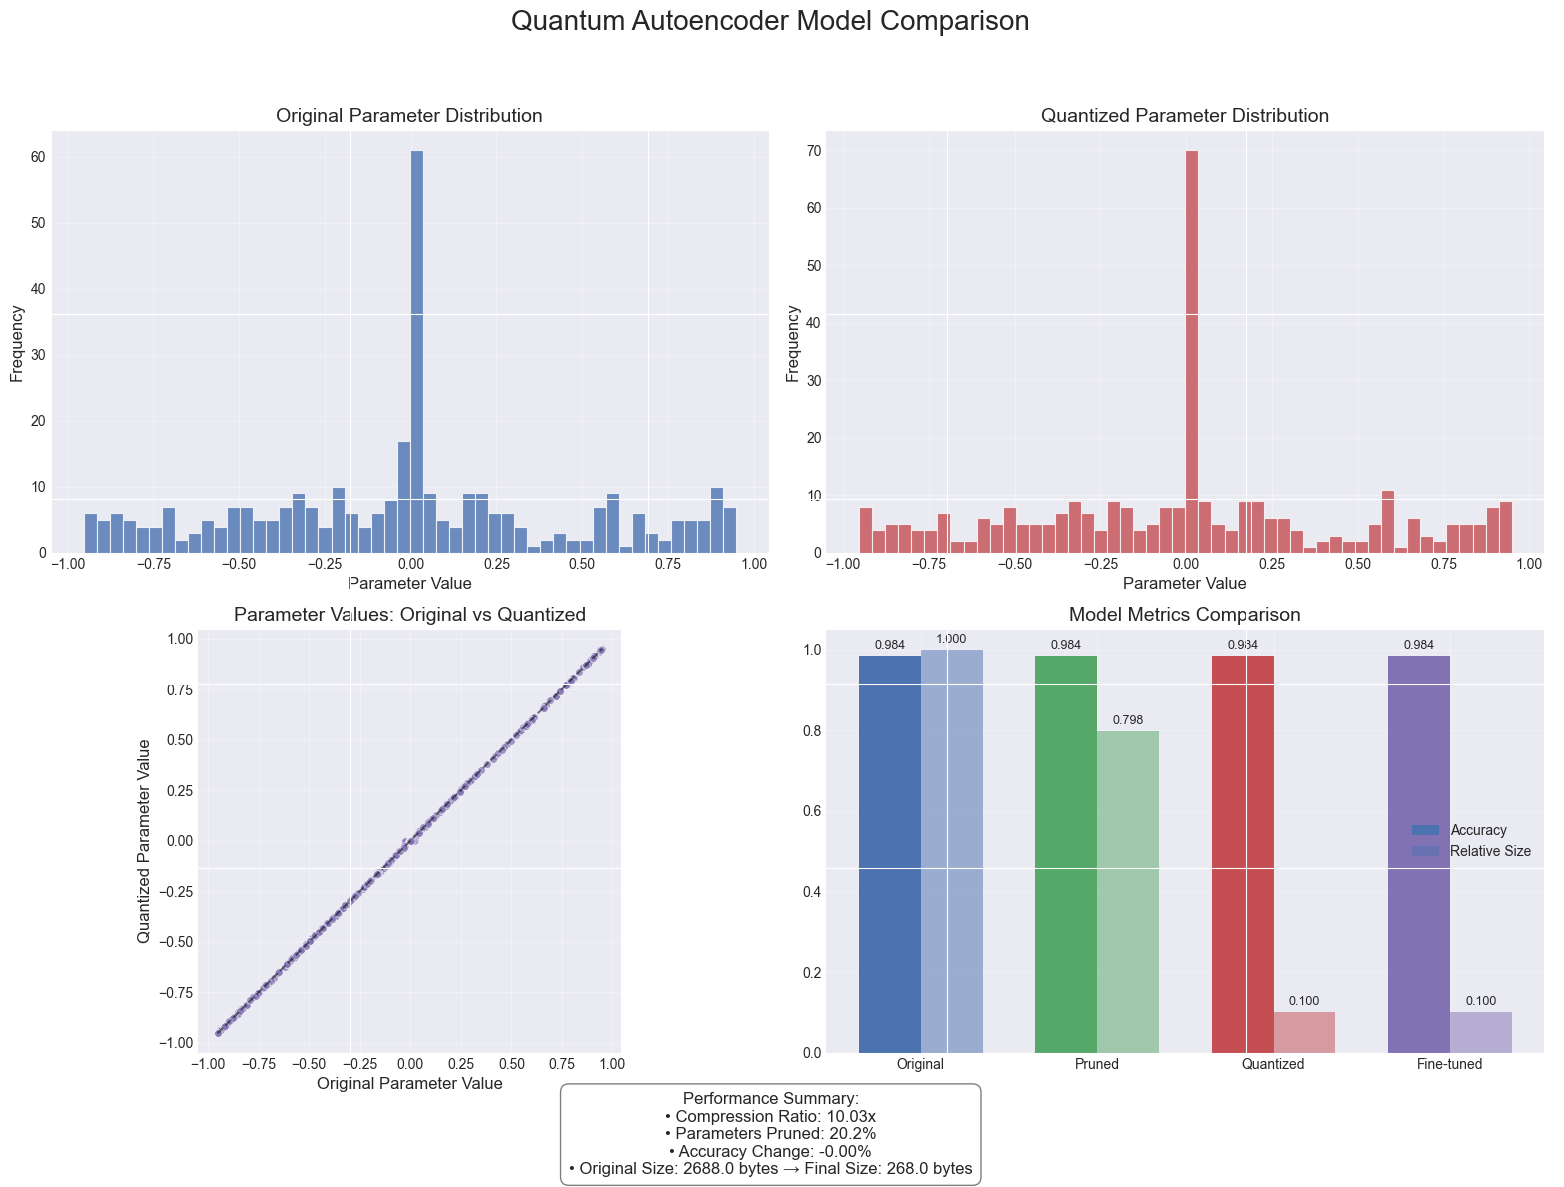

In [6]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()
        
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper Hermitian handling"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Use top eigenvectors with proper normalization
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices]
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Combine eigenvectors
        latent_state = np.zeros(dim, dtype=complex)
        for w, i in zip(weights, top_indices):
            latent_state += np.sqrt(w) * eigenvecs[:, i]
            
        # Ensure proper normalization
        latent_state = latent_state / np.linalg.norm(latent_state)
        return latent_state
        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def apply_quantization(self, bits=8):
        """
        Quantize parameters to specified bit precision
        Returns the original and quantized parameters for comparison
        """
        original_params = self.params.copy()
        
        # Find min and max for scaling
        p_min, p_max = np.min(self.params), np.max(self.params)
        
        # Scale to [0, 2^bits - 1]
        scale = (2**bits - 1) / (p_max - p_min)
        
        # Quantize
        quantized_int = np.round((self.params - p_min) * scale)
        
        # Scale back to original range
        self.params = (quantized_int / scale) + p_min
        
        # Apply pruning mask to ensure quantized pruned values stay at zero
        self.params = self.params * self.pruning_mask
        
        return original_params, self.params

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def evaluate_model(model, X_test):
    """Evaluate model on test data and return accuracy"""
    losses = []
    with torch.no_grad():
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            loss = np.mean((decoded[:len(x)] - x)**2)
            losses.append(loss)
    
    test_loss = np.mean(losses)
    test_accuracy = 1 / (1 + test_loss)
    return test_loss, test_accuracy

def train_model(X, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for quantum autoencoder"""
    set_seeds(seed)
    
    # Use the provided X dataset
    # Split data into train, validation, and test sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)  # 15%/15% val/test split
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # For 78 features, we need 7 qubits (2^6 = 64 < 78 < 2^7 = 128)
    n_qubits = 7
    latent_qubits = 5  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': [], 'test_losses':[], 'test_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            # Initialize batch loss properly for accumulation
            batch_loss = 0.0
            
            for x in batch_data:
                # Convert input to tensor
                x_tensor = torch.tensor(x, dtype=torch.float64)
                
                # Forward pass
                decoded = model.forward(x)
                
                # Ensure decoded is a tensor with proper type
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                # Calculate individual sample loss
                # Only compare against original dimensions
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                
                # Accumulate loss (without requiring grad)
                batch_loss += reconstruction_loss.item()
            
            # Calculate average reconstruction loss for the batch
            avg_recon_loss = batch_loss / len(batch_data)
            
            # Add L2 regularization directly to the final loss calculation
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            # Backward pass on the properly constructed loss
            final_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Record loss for this batch
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        
        # Evaluate on test set
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)

        test_loss = np.mean(test_losses)
        test_accuracy = 1 / (1 + test_loss)
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)

        metrics['test_losses'].append(test_loss)
        metrics['test_accuracies'].append(test_accuracy)
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f} | {test_loss:.4f} | {test_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.998 and train_accuracy >= 0.998:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics, X_test

def compare_models(X, seed=42):
    """Train and compare original, pruned, and quantized models"""
    set_seeds(seed)
    
    # # Create synthetic dataset if needed
    # if X is None:
    #     X, _ = make_classification(n_samples=200, n_features=78, random_state=seed)
    
    # Train original model
    print("Training original model...")
    original_model, _, _, X_test = train_model(X, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_loss, original_accuracy = evaluate_model(original_model, X_test)
    
    # Create pruned model (clone from original)
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Apply pruning (prune 20% of smallest magnitude parameters)
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    pruned_loss, pruned_accuracy = evaluate_model(pruned_model, X_test)
    
    # Create quantized model (clone from pruned)
    print("\nApplying quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    
    # Apply 8-bit quantization
    original_params, quantized_params = quantized_model.apply_quantization(bits=8)
    
    # Evaluate quantized model
    quantized_loss, quantized_accuracy = evaluate_model(quantized_model, X_test)
    
    # Fine-tune quantized model
    print("\nFine-tuning quantized model...")
    # Convert params to tensor for fine-tuning
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)  # Lower learning rate for fine-tuning
    
    # Preprocess data
    X_train, _ = train_test_split(X, test_size=0.3, random_state=seed)
    X_train = preprocess_data(X_train)
    
    # Fine-tuning loop (shorter)
    for epoch in range(20):
        # Apply params to model
        quantized_model.params = params.detach().numpy()
        
        # Batch processing
        batch_idx = np.random.choice(len(X_train), min(8, len(X_train)))
        batch_data = X_train[batch_idx]
        
        # Process batch
        optimizer.zero_grad()
        
        # Track loss as a tensor with gradients
        batch_loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)
        
        for i, x in enumerate(batch_data):
            x_tensor = torch.tensor(x, dtype=torch.float64)
            
            # Set model parameters for this forward pass
            quantized_model.params = params.detach().numpy()
            
            # Forward pass
            decoded = quantized_model.forward(x)
            
            # Ensure decoded is a tensor with proper type
            if not torch.is_tensor(decoded):
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64)
            elif decoded.dtype != torch.float64:
                decoded = decoded.real.to(torch.float64)
            
            # Calculate MSE loss with gradients attached
            if i == 0:
                # For the first sample, create a loss tensor with gradients
                batch_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
            else:
                # For subsequent samples, accumulate loss
                batch_loss = batch_loss + torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
        
        # Calculate average loss
        avg_loss = batch_loss / len(batch_data)
        
        # Add L2 regularization
        final_loss = avg_loss + 0.001 * torch.sum(params**2)
        
        # Backward and optimize
        final_loss.backward()
        optimizer.step()
        
        # Re-quantize after gradient update
        quantized_model.params = params.detach().numpy()
        _, quantized_model.params = quantized_model.apply_quantization(bits=8)
        params.data = torch.tensor(quantized_model.params)
        
        # Keep pruned parameters at zero
        quantized_model.params = quantized_model.params * quantized_model.pruning_mask
        params.data = torch.tensor(quantized_model.params)
        
        if (epoch + 1) % 5 == 0:
            try:
                print(f"Fine-tuning epoch {epoch+1}, Loss: {final_loss.item():.6f}")
            except:
                print(f"Fine-tuning epoch {epoch+1}, Loss calculation failed but training continues")
    
    # Final evaluation of fine-tuned quantized model
    finetuned_loss, finetuned_accuracy = evaluate_model(quantized_model, X_test)
    
    # Calculate compression metrics
    param_count = len(original_model.params)
    original_size = param_count * 64  # 64-bit floating point (8 bytes)
    pruned_size = np.sum(pruned_model.pruning_mask) * 64  # Only non-pruned params
    quantized_size = np.sum(quantized_model.pruning_mask) * 8  # 8-bit quantized non-pruned params
    compression_ratio = original_size / quantized_size
    
    # Print results
    print("\n" + "="*50)
    print("MODEL COMPARISON RESULTS")
    print("="*50)
    print(f"Original Model Accuracy:       {original_accuracy:.6f}")
    print(f"Pruned Model Accuracy:         {pruned_accuracy:.6f}")
    print(f"Quantized Model Accuracy:      {quantized_accuracy:.6f}")
    print(f"Fine-tuned Quantized Accuracy: {finetuned_accuracy:.6f}")
    print("-"*50)
    print(f"Original Size:        {original_size/8:.1f} bytes (100.0%)")
    print(f"After Pruning:        {pruned_size/8:.1f} bytes ({pruned_size/original_size*100:.1f}%)")
    print(f"After Quantization:   {quantized_size/8:.1f} bytes ({quantized_size/original_size*100:.1f}%)")
    print(f"Compression Ratio:    {compression_ratio:.2f}x")
    print(f"Accuracy Change:      {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%")
    
    # Create enhanced visualizations with better styling
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Define a consistent color palette
    colors = {
        'original': '#4C72B0',      # Blue
        'pruned': '#55A868',        # Green
        'quantized': '#C44E52',     # Red
        'finetuned': '#8172B3'      # Purple
    }
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Quantum Autoencoder Model Comparison', fontsize=20, y=0.98)
    
    # Original parameters histogram
    ax1 = plt.subplot(2, 2, 1)
    n, bins, patches = ax1.hist(original_params.flatten(), bins=50, alpha=0.8, 
                               color=colors['original'], edgecolor='white', linewidth=0.8)
    ax1.set_title("Original Parameter Distribution", fontsize=14)
    ax1.set_xlabel("Parameter Value", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.grid(alpha=0.3)
    
    # Quantized parameters histogram
    ax2 = plt.subplot(2, 2, 2)
    n, bins, patches = ax2.hist(quantized_params.flatten(), bins=50, alpha=0.8,
                               color=colors['quantized'], edgecolor='white', linewidth=0.8)
    ax2.set_title("Quantized Parameter Distribution", fontsize=14)
    ax2.set_xlabel("Parameter Value", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.grid(alpha=0.3)
    
    # Highlight parameter changes with scatter plot
    ax3 = plt.subplot(2, 2, 3)
    
    # Only plot a subset of parameters (up to 1000 for visibility)
    max_params = min(1000, len(original_params))
    sample_indices = np.random.choice(len(original_params), max_params, replace=False)
    
    ax3.scatter(original_params.flatten()[sample_indices], 
                quantized_params.flatten()[sample_indices], 
                alpha=0.7, s=30, color=colors['finetuned'], edgecolor='white', linewidth=0.5)
    
    # Add diagonal line for reference
    min_val = min(original_params.min(), quantized_params.min())
    max_val = max(original_params.max(), quantized_params.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax3.set_title("Parameter Values: Original vs Quantized", fontsize=14)
    ax3.set_xlabel("Original Parameter Value", fontsize=12)
    ax3.set_ylabel("Quantized Parameter Value", fontsize=12)
    ax3.grid(alpha=0.3)
    ax3.set_aspect('equal')
    
    # Accuracy and size comparison as a grouped bar chart
    ax4 = plt.subplot(2, 2, 4)
    
    # Group bar data
    x = np.arange(4)  # four groups
    width = 0.35
    
    # First set of bars: Accuracy
    metrics = ["Original", "Pruned", "Quantized", "Fine-tuned"]
    accuracies = [original_accuracy, pruned_accuracy, quantized_accuracy, finetuned_accuracy]
    bars1 = ax4.bar(x - width/2, accuracies, width, label='Accuracy',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']])
    
    # Second set of bars: Relative Size (normalized)
    sizes = [1.0, pruned_size/original_size, quantized_size/original_size, quantized_size/original_size]  # Normalized to original
    bars2 = ax4.bar(x + width/2, sizes, width, label='Relative Size',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']], 
                   alpha=0.5)
    
    # Add labels and styling
    ax4.set_title("Model Metrics Comparison", fontsize=14)
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # Add exact values on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)
    
    autolabel(bars1)
    autolabel(bars2)
    
    # Create a fifth subplot for additional metrics
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    # Add text summary of key metrics
    summary_text = (
        f"Performance Summary:\n"
        f"• Compression Ratio: {compression_ratio:.2f}x\n"
        f"• Parameters Pruned: {pruning_percentage:.1f}%\n"
        f"• Accuracy Change: {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%\n"
        f"• Original Size: {original_size/8:.1f} bytes → Final Size: {quantized_size/8:.1f} bytes"
    )
    
    plt.figtext(0.5, 0.01, summary_text, ha="center", fontsize=12, 
                bbox={"facecolor":"white", "alpha":0.5, "pad":5, "boxstyle":"round,pad=0.5"})
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("quantum_model_comparison.png", dpi=300, bbox_inches='tight')
    
    # Plot training history if metrics are available
    try:
        if isinstance(metrics, dict) and 'train_losses' in metrics:
            fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            fig2.suptitle('Quantum Autoencoder Training History', fontsize=18)
            
            epochs = range(len(metrics['train_losses']))
            
            # Plot losses
            ax1.plot(epochs, metrics['train_losses'], label='Train', color=colors['original'], linewidth=2)
            ax1.plot(epochs, metrics['val_losses'], label='Validation', color=colors['pruned'], linewidth=2)
            ax1.plot(epochs, metrics['test_losses'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax1.set_title('Loss During Training', fontsize=14)
            ax1.set_xlabel('Epochs', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # Plot accuracy
            ax2.plot(epochs, metrics['train_accuracies'], label='Train', color=colors['original'], linewidth=2)
            ax2.plot(epochs, metrics['val_accuracies'], label='Validation', color=colors['pruned'], linewidth=2)
            ax2.plot(epochs, metrics['test_accuracies'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax2.set_title('Accuracy During Training', fontsize=14)
            ax2.set_xlabel('Epochs', fontsize=12)
            ax2.set_ylabel('Accuracy', fontsize=12)
            ax2.legend()
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig("quantum_training_history.png", dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Could not plot training history: {e}")
    
    return {
        "original_accuracy": original_accuracy,
        "pruned_accuracy": pruned_accuracy, 
        "quantized_accuracy": quantized_accuracy,
        "finetuned_accuracy": finetuned_accuracy,
        "compression_ratio": compression_ratio,
        "pruning_percentage": pruning_percentage
    }

# # Generate synthetic data for testing if needed
# def generate_synthetic_data(n_samples=200, n_features=78, seed=42):
#     set_seeds(seed)
#     X, _ = make_classification(n_samples=n_samples, n_features=n_features, random_state=seed)
#     return X

if __name__ == "__main__":
    # To use synthetic data, uncomment this line:
    # X = generate_synthetic_data()
    
    # For real data, make sure X is defined
    # X = ...  # Your data with approx 78 features
    
    # Compare models and get results
    results = compare_models(X)
    
    # Print summary
    print("\nSUMMARY:")
    print(f"Original model accuracy: {results['original_accuracy']:.6f}")
    print(f"Final model accuracy: {results['finetuned_accuracy']:.6f}")
    print(f"Compression ratio: {results['compression_ratio']:.2f}x")
    print(f"Accuracy impact: {(results['finetuned_accuracy']-results['original_accuracy'])/results['original_accuracy']*100:.2f}%")

## TinyQL 7-Bits

Training original model...

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc
---------------------------------------------------------------------------
    0 | 0.1661 | 0.8575 | 0.0167 | 0.9836 | 0.0170 | 0.9833
    1 | 0.1145 | 0.8973 | 0.0164 | 0.9839 | 0.0166 | 0.9837
    2 | 0.0801 | 0.9259 | 0.0173 | 0.9830 | 0.0164 | 0.9839
    3 | 0.0577 | 0.9455 | 0.0170 | 0.9833 | 0.0169 | 0.9834
    4 | 0.0425 | 0.9592 | 0.0170 | 0.9833 | 0.0170 | 0.9832
    5 | 0.0327 | 0.9684 | 0.0173 | 0.9830 | 0.0176 | 0.9827
    6 | 0.0274 | 0.9733 | 0.0182 | 0.9821 | 0.0188 | 0.9816
    7 | 0.0245 | 0.9761 | 0.0192 | 0.9811 | 0.0198 | 0.9806
    8 | 0.0229 | 0.9776 | 0.0200 | 0.9804 | 0.0205 | 0.9799
    9 | 0.0217 | 0.9788 | 0.0207 | 0.9797 | 0.0209 | 0.9795
   10 | 0.0218 | 0.9787 | 0.0212 | 0.9792 | 0.0213 | 0.9791
   11 | 0.0217 | 0.9787 | 0.0217 | 0.9788 | 0.0216 | 0.9788

Early stopping triggered!

Evaluating original model...

Applying pruning...
Prun

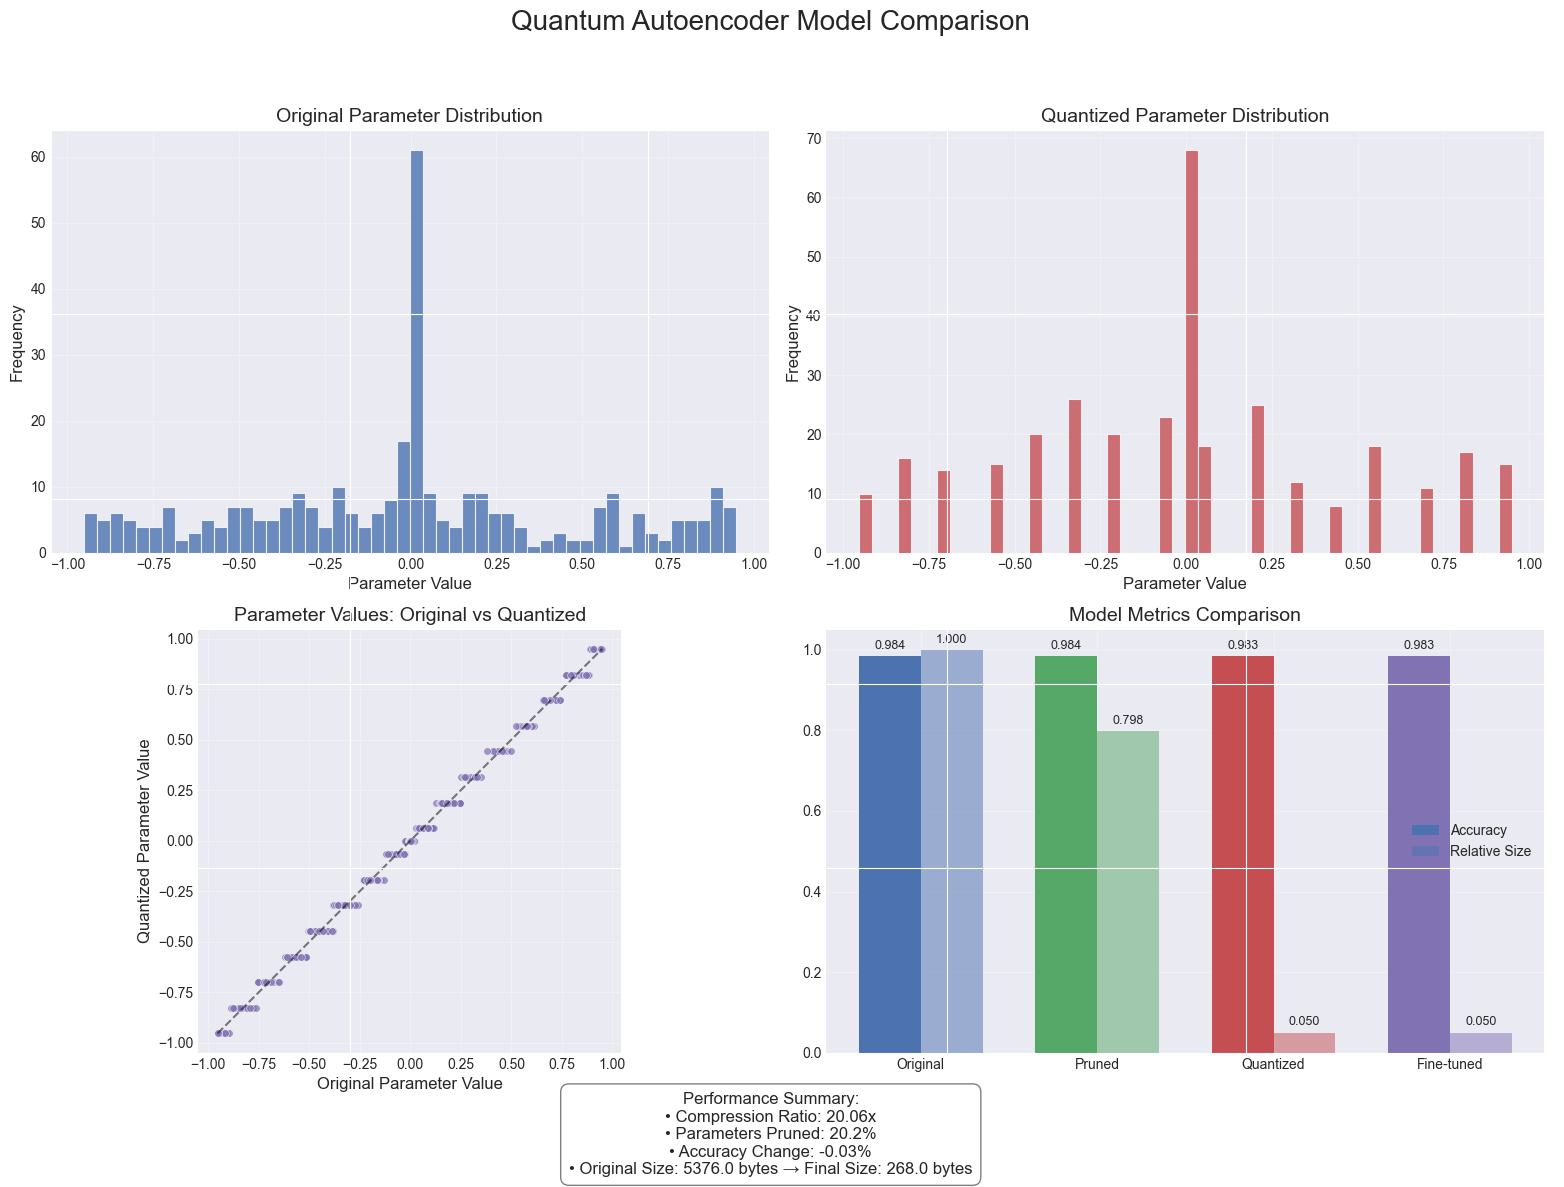

In [7]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()
        
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper Hermitian handling"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Use top eigenvectors with proper normalization
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices]
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Combine eigenvectors
        latent_state = np.zeros(dim, dtype=complex)
        for w, i in zip(weights, top_indices):
            latent_state += np.sqrt(w) * eigenvecs[:, i]
            
        # Ensure proper normalization
        latent_state = latent_state / np.linalg.norm(latent_state)
        return latent_state
        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def apply_quantization(self, bits=4):
        """
        Quantize parameters to specified bit precision
        Returns the original and quantized parameters for comparison
        """
        original_params = self.params.copy()
        
        # Find min and max for scaling
        p_min, p_max = np.min(self.params), np.max(self.params)
        
        # Scale to [0, 2^bits - 1]
        scale = (2**bits - 1) / (p_max - p_min)
        
        # Quantize
        quantized_int = np.round((self.params - p_min) * scale)
        
        # Scale back to original range
        self.params = (quantized_int / scale) + p_min
        
        # Apply pruning mask to ensure quantized pruned values stay at zero
        self.params = self.params * self.pruning_mask
        
        return original_params, self.params

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def evaluate_model(model, X_test):
    """Evaluate model on test data and return accuracy"""
    losses = []
    with torch.no_grad():
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            loss = np.mean((decoded[:len(x)] - x)**2)
            losses.append(loss)
    
    test_loss = np.mean(losses)
    test_accuracy = 1 / (1 + test_loss)
    return test_loss, test_accuracy

def train_model(X, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for quantum autoencoder"""
    set_seeds(seed)
    
    # Use the provided X dataset
    # Split data into train, validation, and test sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)  # 15%/15% val/test split
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # For 78 features, we need 7 qubits (2^6 = 64 < 78 < 2^7 = 128)
    n_qubits = 7
    latent_qubits = 5  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': [], 'test_losses':[], 'test_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            # Initialize batch loss properly for accumulation
            batch_loss = 0.0
            
            for x in batch_data:
                # Convert input to tensor
                x_tensor = torch.tensor(x, dtype=torch.float64)
                
                # Forward pass
                decoded = model.forward(x)
                
                # Ensure decoded is a tensor with proper type
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                # Calculate individual sample loss
                # Only compare against original dimensions
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                
                # Accumulate loss (without requiring grad)
                batch_loss += reconstruction_loss.item()
            
            # Calculate average reconstruction loss for the batch
            avg_recon_loss = batch_loss / len(batch_data)
            
            # Add L2 regularization directly to the final loss calculation
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            # Backward pass on the properly constructed loss
            final_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Record loss for this batch
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        
        # Evaluate on test set
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)

        test_loss = np.mean(test_losses)
        test_accuracy = 1 / (1 + test_loss)
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)

        metrics['test_losses'].append(test_loss)
        metrics['test_accuracies'].append(test_accuracy)
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f} | {test_loss:.4f} | {test_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.998 and train_accuracy >= 0.998:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics, X_test

def compare_models(X, seed=42):
    """Train and compare original, pruned, and quantized models"""
    set_seeds(seed)
    
    # # Create synthetic dataset if needed
    # if X is None:
    #     X, _ = make_classification(n_samples=200, n_features=78, random_state=seed)
    
    # Train original model
    print("Training original model...")
    original_model, _, _, X_test = train_model(X, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_loss, original_accuracy = evaluate_model(original_model, X_test)
    
    # Create pruned model (clone from original)
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Apply pruning (prune 20% of smallest magnitude parameters)
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    pruned_loss, pruned_accuracy = evaluate_model(pruned_model, X_test)
    
    # Create quantized model (clone from pruned)
    print("\nApplying quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    
    # Apply 8-bit quantization
    original_params, quantized_params = quantized_model.apply_quantization(bits=4)
    
    # Evaluate quantized model
    quantized_loss, quantized_accuracy = evaluate_model(quantized_model, X_test)
    
    # Fine-tune quantized model
    print("\nFine-tuning quantized model...")
    # Convert params to tensor for fine-tuning
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)  # Lower learning rate for fine-tuning
    
    # Preprocess data
    X_train, _ = train_test_split(X, test_size=0.3, random_state=seed)
    X_train = preprocess_data(X_train)
    
    # Fine-tuning loop (shorter)
    for epoch in range(20):
        # Apply params to model
        quantized_model.params = params.detach().numpy()
        
        # Batch processing
        batch_idx = np.random.choice(len(X_train), min(8, len(X_train)))
        batch_data = X_train[batch_idx]
        
        # Process batch
        optimizer.zero_grad()
        
        # Track loss as a tensor with gradients
        batch_loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)
        
        for i, x in enumerate(batch_data):
            x_tensor = torch.tensor(x, dtype=torch.float64)
            
            # Set model parameters for this forward pass
            quantized_model.params = params.detach().numpy()
            
            # Forward pass
            decoded = quantized_model.forward(x)
            
            # Ensure decoded is a tensor with proper type
            if not torch.is_tensor(decoded):
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64)
            elif decoded.dtype != torch.float64:
                decoded = decoded.real.to(torch.float64)
            
            # Calculate MSE loss with gradients attached
            if i == 0:
                # For the first sample, create a loss tensor with gradients
                batch_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
            else:
                # For subsequent samples, accumulate loss
                batch_loss = batch_loss + torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
        
        # Calculate average loss
        avg_loss = batch_loss / len(batch_data)
        
        # Add L2 regularization
        final_loss = avg_loss + 0.001 * torch.sum(params**2)
        
        # Backward and optimize
        final_loss.backward()
        optimizer.step()
        
        # Re-quantize after gradient update
        quantized_model.params = params.detach().numpy()
        _, quantized_model.params = quantized_model.apply_quantization(bits=8)
        params.data = torch.tensor(quantized_model.params)
        
        # Keep pruned parameters at zero
        quantized_model.params = quantized_model.params * quantized_model.pruning_mask
        params.data = torch.tensor(quantized_model.params)
        
        if (epoch + 1) % 5 == 0:
            try:
                print(f"Fine-tuning epoch {epoch+1}, Loss: {final_loss.item():.6f}")
            except:
                print(f"Fine-tuning epoch {epoch+1}, Loss calculation failed but training continues")
    
    # Final evaluation of fine-tuned quantized model
    finetuned_loss, finetuned_accuracy = evaluate_model(quantized_model, X_test)
    
    # Calculate compression metrics
    param_count = len(original_model.params)
    original_size = param_count * 64  # 64-bit floating point (8 bytes)
    pruned_size = np.sum(pruned_model.pruning_mask) * 64  # Only non-pruned params
    quantized_size = np.sum(quantized_model.pruning_mask) * 4  # 8-bit quantized non-pruned params
    compression_ratio = original_size / quantized_size
    
    # Print results
    print("\n" + "="*50)
    print("MODEL COMPARISON RESULTS")
    print("="*50)
    print(f"Original Model Accuracy:       {original_accuracy:.6f}")
    print(f"Pruned Model Accuracy:         {pruned_accuracy:.6f}")
    print(f"Quantized Model Accuracy:      {quantized_accuracy:.6f}")
    print(f"Fine-tuned Quantized Accuracy: {finetuned_accuracy:.6f}")
    print("-"*50)
    print(f"Original Size:        {original_size/4:.1f} bytes (100.0%)")
    print(f"After Pruning:        {pruned_size/4:.1f} bytes ({pruned_size/original_size*100:.1f}%)")
    print(f"After Quantization:   {quantized_size/4:.1f} bytes ({quantized_size/original_size*100:.1f}%)")
    print(f"Compression Ratio:    {compression_ratio:.2f}x")
    print(f"Accuracy Change:      {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%")
    
    # Create enhanced visualizations with better styling
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Define a consistent color palette
    colors = {
        'original': '#4C72B0',      # Blue
        'pruned': '#55A868',        # Green
        'quantized': '#C44E52',     # Red
        'finetuned': '#8172B3'      # Purple
    }
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Quantum Autoencoder Model Comparison', fontsize=20, y=0.98)
    
    # Original parameters histogram
    ax1 = plt.subplot(2, 2, 1)
    n, bins, patches = ax1.hist(original_params.flatten(), bins=50, alpha=0.8, 
                               color=colors['original'], edgecolor='white', linewidth=0.8)
    ax1.set_title("Original Parameter Distribution", fontsize=14)
    ax1.set_xlabel("Parameter Value", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.grid(alpha=0.3)
    
    # Quantized parameters histogram
    ax2 = plt.subplot(2, 2, 2)
    n, bins, patches = ax2.hist(quantized_params.flatten(), bins=50, alpha=0.8,
                               color=colors['quantized'], edgecolor='white', linewidth=0.8)
    ax2.set_title("Quantized Parameter Distribution", fontsize=14)
    ax2.set_xlabel("Parameter Value", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.grid(alpha=0.3)
    
    # Highlight parameter changes with scatter plot
    ax3 = plt.subplot(2, 2, 3)
    
    # Only plot a subset of parameters (up to 1000 for visibility)
    max_params = min(1000, len(original_params))
    sample_indices = np.random.choice(len(original_params), max_params, replace=False)
    
    ax3.scatter(original_params.flatten()[sample_indices], 
                quantized_params.flatten()[sample_indices], 
                alpha=0.7, s=30, color=colors['finetuned'], edgecolor='white', linewidth=0.5)
    
    # Add diagonal line for reference
    min_val = min(original_params.min(), quantized_params.min())
    max_val = max(original_params.max(), quantized_params.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax3.set_title("Parameter Values: Original vs Quantized", fontsize=14)
    ax3.set_xlabel("Original Parameter Value", fontsize=12)
    ax3.set_ylabel("Quantized Parameter Value", fontsize=12)
    ax3.grid(alpha=0.3)
    ax3.set_aspect('equal')
    
    # Accuracy and size comparison as a grouped bar chart
    ax4 = plt.subplot(2, 2, 4)
    
    # Group bar data
    x = np.arange(4)  # four groups
    width = 0.35
    
    # First set of bars: Accuracy
    metrics = ["Original", "Pruned", "Quantized", "Fine-tuned"]
    accuracies = [original_accuracy, pruned_accuracy, quantized_accuracy, finetuned_accuracy]
    bars1 = ax4.bar(x - width/2, accuracies, width, label='Accuracy',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']])
    
    # Second set of bars: Relative Size (normalized)
    sizes = [1.0, pruned_size/original_size, quantized_size/original_size, quantized_size/original_size]  # Normalized to original
    bars2 = ax4.bar(x + width/2, sizes, width, label='Relative Size',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']], 
                   alpha=0.5)
    
    # Add labels and styling
    ax4.set_title("Model Metrics Comparison", fontsize=14)
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # Add exact values on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)
    
    autolabel(bars1)
    autolabel(bars2)
    
    # Create a fifth subplot for additional metrics
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    # Add text summary of key metrics
    summary_text = (
        f"Performance Summary:\n"
        f"• Compression Ratio: {compression_ratio:.2f}x\n"
        f"• Parameters Pruned: {pruning_percentage:.1f}%\n"
        f"• Accuracy Change: {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%\n"
        f"• Original Size: {original_size/4:.1f} bytes → Final Size: {quantized_size/4:.1f} bytes"
    )
    
    plt.figtext(0.5, 0.01, summary_text, ha="center", fontsize=12, 
                bbox={"facecolor":"white", "alpha":0.5, "pad":5, "boxstyle":"round,pad=0.5"})
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("quantum_model_comparison.png", dpi=300, bbox_inches='tight')
    
    # Plot training history if metrics are available
    try:
        if isinstance(metrics, dict) and 'train_losses' in metrics:
            fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            fig2.suptitle('Quantum Autoencoder Training History', fontsize=18)
            
            epochs = range(len(metrics['train_losses']))
            
            # Plot losses
            ax1.plot(epochs, metrics['train_losses'], label='Train', color=colors['original'], linewidth=2)
            ax1.plot(epochs, metrics['val_losses'], label='Validation', color=colors['pruned'], linewidth=2)
            ax1.plot(epochs, metrics['test_losses'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax1.set_title('Loss During Training', fontsize=14)
            ax1.set_xlabel('Epochs', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # Plot accuracy
            ax2.plot(epochs, metrics['train_accuracies'], label='Train', color=colors['original'], linewidth=2)
            ax2.plot(epochs, metrics['val_accuracies'], label='Validation', color=colors['pruned'], linewidth=2)
            ax2.plot(epochs, metrics['test_accuracies'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax2.set_title('Accuracy During Training', fontsize=14)
            ax2.set_xlabel('Epochs', fontsize=12)
            ax2.set_ylabel('Accuracy', fontsize=12)
            ax2.legend()
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig("quantum_training_history.png", dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Could not plot training history: {e}")
    
    return {
        "original_accuracy": original_accuracy,
        "pruned_accuracy": pruned_accuracy, 
        "quantized_accuracy": quantized_accuracy,
        "finetuned_accuracy": finetuned_accuracy,
        "compression_ratio": compression_ratio,
        "pruning_percentage": pruning_percentage
    }

# # Generate synthetic data for testing if needed
# def generate_synthetic_data(n_samples=200, n_features=78, seed=42):
#     set_seeds(seed)
#     X, _ = make_classification(n_samples=n_samples, n_features=n_features, random_state=seed)
#     return X

if __name__ == "__main__":
    # To use synthetic data, uncomment this line:
    # X = generate_synthetic_data()
    
    # For real data, make sure X is defined
    # X = ...  # Your data with approx 78 features
    
    # Compare models and get results
    results = compare_models(X)
    
    # Print summary
    print("\nSUMMARY:")
    print(f"Original model accuracy: {results['original_accuracy']:.6f}")
    print(f"Final model accuracy: {results['finetuned_accuracy']:.6f}")
    print(f"Compression ratio: {results['compression_ratio']:.2f}x")
    print(f"Accuracy impact: {(results['finetuned_accuracy']-results['original_accuracy'])/results['original_accuracy']*100:.2f}%")

Enhanced Quantum Autoencoder with Classification Metrics

Running SUPERVISED example (with anomaly labels)...
Generating synthetic anomaly detection data...
Dataset: 200 samples, 78 features
Normal samples: 170, Anomalous samples: 30
Training original model...

Training Progress:
Epoch | Train Loss | Val Loss | Test Loss | Train P/R/F1/AUC | Val P/R/F1/AUC | Test P/R/F1/AUC
------------------------------------------------------------------------------------------------------------------------
    0 | 0.1847   | 0.0168 | 0.0168  | 0.00/0.00/0.00/0.49 | 0.00/0.00/0.00/0.29 | 0.00/0.00/0.00/0.49
    1 | 0.158397 | 0.016881 | 0.016686
    2 | 0.136724 | 0.017290 | 0.016850
    3 | 0.117839 | 0.017605 | 0.017005
    4 | 0.101650 | 0.017550 | 0.016814
    5 | 0.0882   | 0.0171 | 0.0165  | 0.00/0.00/0.00/0.63 | 0.00/0.00/0.00/0.47 | 0.00/0.00/0.00/0.71
    6 | 0.076375 | 0.016744 | 0.016496
    7 | 0.066467 | 0.016611 | 0.016661
    8 | 0.058166 | 0.016642 | 0.016785
    9 | 0.051226 | 0.0166

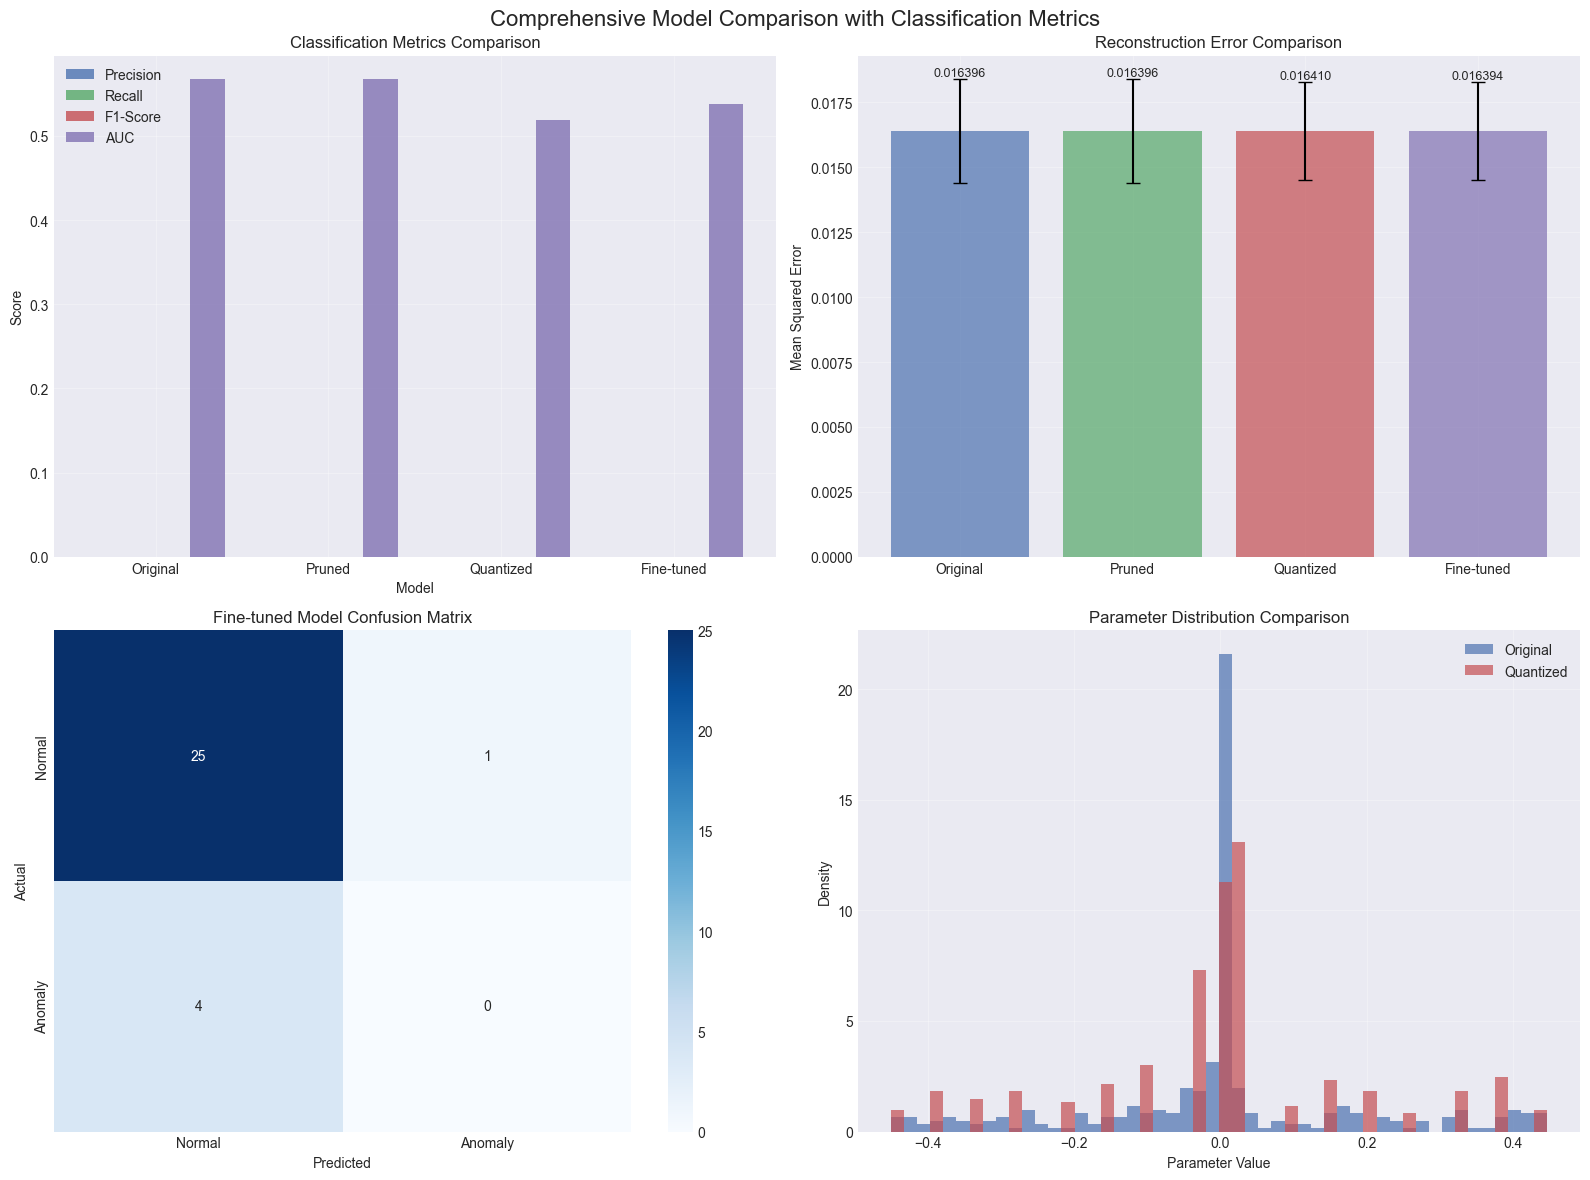

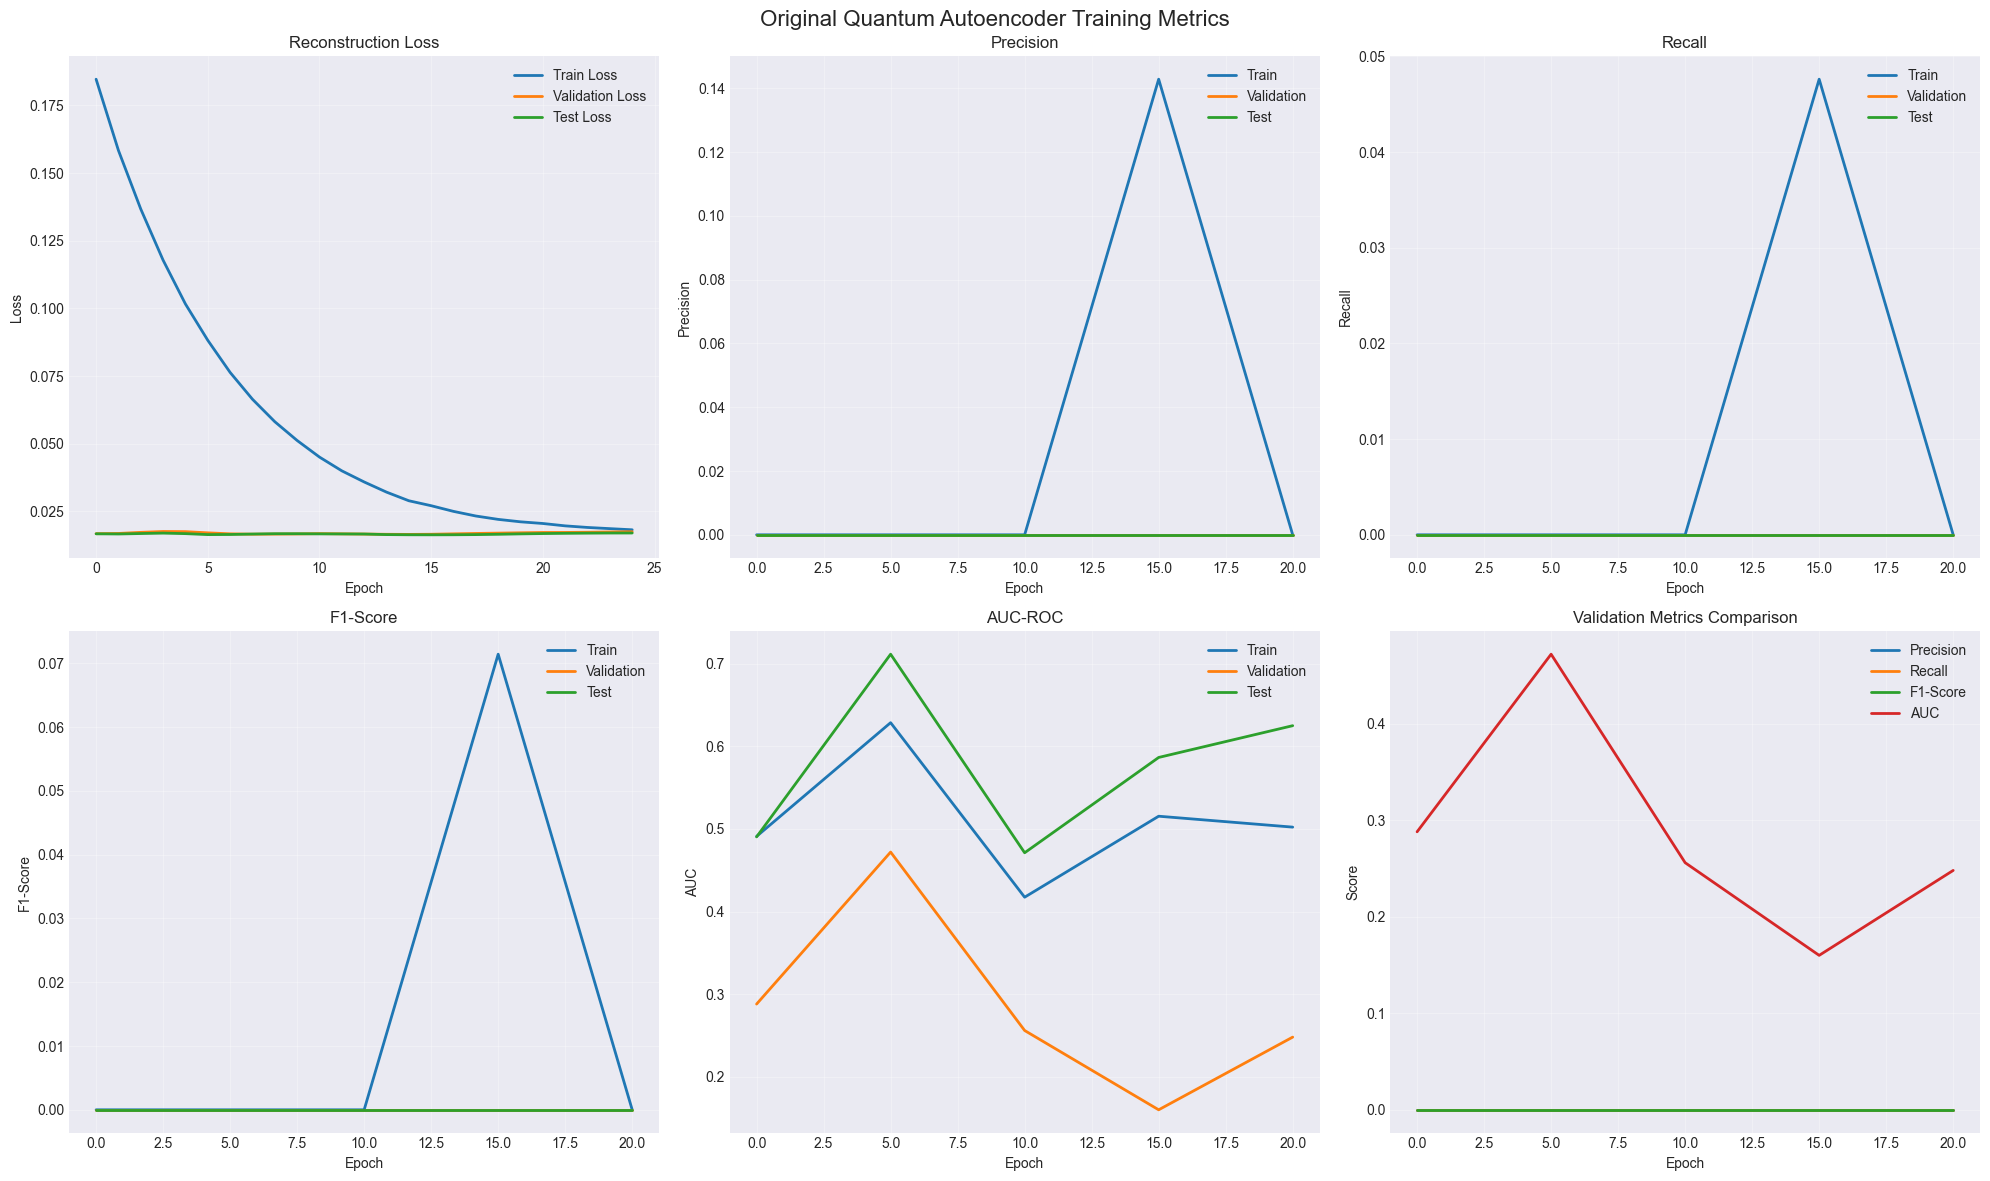


Analysis complete! Check the generated plots for detailed comparisons.


In [8]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import time
import matplotlib.pyplot as plt
import seaborn as sns

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
        
        # For anomaly detection threshold
        self.anomaly_threshold = None
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()
        
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper Hermitian handling"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Use top eigenvectors with proper normalization
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices]
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Combine eigenvectors
        latent_state = np.zeros(dim, dtype=complex)
        for w, i in zip(weights, top_indices):
            latent_state += np.sqrt(w) * eigenvecs[:, i]
            
        # Ensure proper normalization
        latent_state = latent_state / np.linalg.norm(latent_state)
        return latent_state
        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def get_reconstruction_error(self, x):
        """Calculate reconstruction error for anomaly detection"""
        decoded = self.forward(x)
        if torch.is_tensor(decoded):
            decoded = decoded.real.detach().numpy()
        else:
            decoded = np.real(decoded)
        
        # Calculate MSE between input and reconstruction (only for original dimensions)
        error = np.mean((decoded[:len(x)] - x)**2)
        return error
    
    def set_anomaly_threshold(self, X_normal, percentile=95):
        """Set anomaly threshold based on normal data reconstruction errors"""
        errors = []
        for x in X_normal:
            error = self.get_reconstruction_error(x)
            errors.append(error)
        
        self.anomaly_threshold = np.percentile(errors, percentile)
        return self.anomaly_threshold
    
    def predict_anomaly(self, x):
        """Predict if input is anomaly based on reconstruction error"""
        if self.anomaly_threshold is None:
            raise ValueError("Anomaly threshold not set. Call set_anomaly_threshold() first.")
        
        error = self.get_reconstruction_error(x)
        return 1 if error > self.anomaly_threshold else 0  # 1 for anomaly, 0 for normal
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def apply_quantization(self, bits=4):
        """
        Quantize parameters to specified bit precision
        Returns the original and quantized parameters for comparison
        """
        original_params = self.params.copy()
        
        # Find min and max for scaling
        p_min, p_max = np.min(self.params), np.max(self.params)
        
        # Scale to [0, 2^bits - 1]
        scale = (2**bits - 1) / (p_max - p_min)
        
        # Quantize
        quantized_int = np.round((self.params - p_min) * scale)
        
        # Scale back to original range
        self.params = (quantized_int / scale) + p_min
        
        # Apply pruning mask to ensure quantized pruned values stay at zero
        self.params = self.params * self.pruning_mask
        
        return original_params, self.params

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def calculate_classification_metrics(y_true, y_pred, y_scores=None):
    """Calculate comprehensive classification metrics"""
    metrics = {}
    
    # Basic metrics
    metrics['precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, zero_division=0)
    metrics['f1_score'] = f1_score(y_true, y_pred, zero_division=0)
    
    # AUC if scores are provided
    if y_scores is not None:
        try:
            metrics['auc'] = roc_auc_score(y_true, y_scores)
        except ValueError:
            metrics['auc'] = 0.0  # Handle case where only one class present
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['true_negatives'] = tn
    metrics['false_positives'] = fp
    metrics['false_negatives'] = fn
    metrics['true_positives'] = tp
    
    # Additional metrics
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
    
    return metrics

def evaluate_model_with_metrics(model, X_test, y_test=None):
    """Evaluate model with comprehensive metrics"""
    reconstruction_errors = []
    predictions = []
    
    with torch.no_grad():
        for x in X_test:
            error = model.get_reconstruction_error(x)
            reconstruction_errors.append(error)
            
            # Get binary prediction if threshold is set
            if model.anomaly_threshold is not None:
                pred = model.predict_anomaly(x)
                predictions.append(pred)
    
    results = {
        'reconstruction_errors': reconstruction_errors,
        'mean_reconstruction_error': np.mean(reconstruction_errors),
        'std_reconstruction_error': np.std(reconstruction_errors)
    }
    
    # If ground truth labels are provided, calculate classification metrics
    if y_test is not None and model.anomaly_threshold is not None:
        classification_metrics = calculate_classification_metrics(
            y_test, predictions, reconstruction_errors
        )
        results.update(classification_metrics)
        results['predictions'] = predictions
    
    return results

def train_model_with_metrics(X, y=None, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process with comprehensive metrics tracking"""
    set_seeds(seed)
    
    # Split data into train, validation, and test sets
    if y is not None:
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)
    else:
        X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
        X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)
        y_train = y_val = y_test = None
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # For 78 features, we need 7 qubits (2^6 = 64 < 78 < 2^7 = 128)
    n_qubits = 7
    latent_qubits = 5  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_val_loss = float('inf')
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {
        'train_losses': [], 'val_losses': [], 'test_losses': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [], 'train_auc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_auc': [],
        'test_precision': [], 'test_recall': [], 'test_f1': [], 'test_auc': []
    }
    
    print("\nTraining Progress:")
    if y is not None:
        print("Epoch | Train Loss | Val Loss | Test Loss | Train P/R/F1/AUC | Val P/R/F1/AUC | Test P/R/F1/AUC")
        print("-" * 120)
    else:
        print("Epoch | Train Loss | Val Loss | Test Loss")
        print("-" * 45)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            batch_loss = 0.0
            
            for x in batch_data:
                x_tensor = torch.tensor(x, dtype=torch.float64)
                decoded = model.forward(x)
                
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                batch_loss += reconstruction_loss.item()
            
            avg_recon_loss = batch_loss / len(batch_data)
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            final_loss.backward()
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            optimizer.step()
            
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        
        # Validation loss
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        val_loss = np.mean(val_losses)
        
        # Test loss
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)
        test_loss = np.mean(test_losses)
        
        metrics['train_losses'].append(train_loss)
        metrics['val_losses'].append(val_loss)
        metrics['test_losses'].append(test_loss)
        
        # Calculate classification metrics if labels are available
        if y is not None and epoch % 5 == 0:  # Calculate every 5 epochs to save time
            # Set threshold based on normal samples from training set (assuming label 0 is normal)
            normal_train_idx = np.where(y_train == 0)[0] if len(np.unique(y_train)) > 1 else np.arange(len(y_train))
            if len(normal_train_idx) > 0:
                X_normal_train = X_train[normal_train_idx]
                model.set_anomaly_threshold(X_normal_train, percentile=95)
                
                # Evaluate on all sets
                train_metrics = evaluate_model_with_metrics(model, X_train, y_train)
                val_metrics = evaluate_model_with_metrics(model, X_val, y_val)
                test_metrics = evaluate_model_with_metrics(model, X_test, y_test)
                
                # Store metrics
                for dataset, dataset_metrics in [('train', train_metrics), ('val', val_metrics), ('test', test_metrics)]:
                    metrics[f'{dataset}_precision'].append(dataset_metrics.get('precision', 0))
                    metrics[f'{dataset}_recall'].append(dataset_metrics.get('recall', 0))
                    metrics[f'{dataset}_f1'].append(dataset_metrics.get('f1_score', 0))
                    metrics[f'{dataset}_auc'].append(dataset_metrics.get('auc', 0))
        
        # Print progress
        if y is not None and epoch % 5 == 0 and len(metrics['train_precision']) > 0:
            train_p, train_r, train_f1, train_auc = (
                metrics['train_precision'][-1], metrics['train_recall'][-1],
                metrics['train_f1'][-1], metrics['train_auc'][-1]
            )
            val_p, val_r, val_f1, val_auc = (
                metrics['val_precision'][-1], metrics['val_recall'][-1],
                metrics['val_f1'][-1], metrics['val_auc'][-1]
            )
            test_p, test_r, test_f1, test_auc = (
                metrics['test_precision'][-1], metrics['test_recall'][-1],
                metrics['test_f1'][-1], metrics['test_auc'][-1]
            )
            print(f"{epoch:5d} | {train_loss:.4f}   | {val_loss:.4f} | {test_loss:.4f}  | "
                  f"{train_p:.2f}/{train_r:.2f}/{train_f1:.2f}/{train_auc:.2f} | "
                  f"{val_p:.2f}/{val_r:.2f}/{val_f1:.2f}/{val_auc:.2f} | "
                  f"{test_p:.2f}/{test_r:.2f}/{test_f1:.2f}/{test_auc:.2f}")
        else:
            print(f"{epoch:5d} | {train_loss:.6f} | {val_loss:.6f} | {test_loss:.6f}")
        
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
    
    model.params = best_params.numpy()
    
    # Final evaluation with all metrics
    if y is not None:
        # Set final threshold
        normal_train_idx = np.where(y_train == 0)[0] if len(np.unique(y_train)) > 1 else np.arange(len(y_train))
        if len(normal_train_idx) > 0:
            X_normal_train = X_train[normal_train_idx]
            model.set_anomaly_threshold(X_normal_train, percentile=95)
        
        final_train_metrics = evaluate_model_with_metrics(model, X_train, y_train)
        final_val_metrics = evaluate_model_with_metrics(model, X_val, y_val)
        final_test_metrics = evaluate_model_with_metrics(model, X_test, y_test)
        
        print("\n" + "="*80)
        print("FINAL EVALUATION RESULTS")
        print("="*80)
        
        for dataset_name, dataset_metrics in [("Train", final_train_metrics), 
                                               ("Validation", final_val_metrics), 
                                               ("Test", final_test_metrics)]:
            print(f"\n{dataset_name} Set:")
            print(f"  Reconstruction Error: {dataset_metrics['mean_reconstruction_error']:.6f} ± {dataset_metrics['std_reconstruction_error']:.6f}")
            if 'precision' in dataset_metrics:
                print(f"  Precision: {dataset_metrics['precision']:.4f}")
                print(f"  Recall: {dataset_metrics['recall']:.4f}")
                print(f"  F1-Score: {dataset_metrics['f1_score']:.4f}")
                print(f"  AUC: {dataset_metrics['auc']:.4f}")
                print(f"  Specificity: {dataset_metrics['specificity']:.4f}")
                print(f"  Accuracy: {dataset_metrics['accuracy']:.4f}")
                print(f"  Confusion Matrix: TP={dataset_metrics['true_positives']}, "
                      f"FP={dataset_metrics['false_positives']}, "
                      f"TN={dataset_metrics['true_negatives']}, "
                      f"FN={dataset_metrics['false_negatives']}")
    
    return model, metrics, X_test, y_test

def plot_enhanced_metrics(metrics, title_prefix="Quantum Autoencoder"):
    """Plot comprehensive training metrics"""
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle(f'{title_prefix} Training Metrics', fontsize=16, y=0.98)
    
    # Loss plot
    ax1 = plt.subplot(2, 3, 1)
    epochs = range(len(metrics['train_losses']))
    ax1.plot(epochs, metrics['train_losses'], label='Train Loss', linewidth=2)
    ax1.plot(epochs, metrics['val_losses'], label='Validation Loss', linewidth=2)
    ax1.plot(epochs, metrics['test_losses'], label='Test Loss', linewidth=2)
    ax1.set_title('Reconstruction Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Classification metrics if available
    if len(metrics.get('train_precision', [])) > 0:
        metric_epochs = np.arange(0, len(metrics['train_losses']), 5)[:len(metrics['train_precision'])]
        
        # Precision plot
        ax2 = plt.subplot(2, 3, 2)
        ax2.plot(metric_epochs, metrics['train_precision'], label='Train', linewidth=2)
        ax2.plot(metric_epochs, metrics['val_precision'], label='Validation', linewidth=2)
        ax2.plot(metric_epochs, metrics['test_precision'], label='Test', linewidth=2)
        ax2.set_title('Precision')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Precision')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Recall plot
        ax3 = plt.subplot(2, 3, 3)
        ax3.plot(metric_epochs, metrics['train_recall'], label='Train', linewidth=2)
        ax3.plot(metric_epochs, metrics['val_recall'], label='Validation', linewidth=2)
        ax3.plot(metric_epochs, metrics['test_recall'], label='Test', linewidth=2)
        ax3.set_title('Recall')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Recall')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # F1-Score plot
        ax4 = plt.subplot(2, 3, 4)
        ax4.plot(metric_epochs, metrics['train_f1'], label='Train', linewidth=2)
        ax4.plot(metric_epochs, metrics['val_f1'], label='Validation', linewidth=2)
        ax4.plot(metric_epochs, metrics['test_f1'], label='Test', linewidth=2)
        ax4.set_title('F1-Score')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('F1-Score')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # AUC plot
        ax5 = plt.subplot(2, 3, 5)
        ax5.plot(metric_epochs, metrics['train_auc'], label='Train', linewidth=2)
        ax5.plot(metric_epochs, metrics['val_auc'], label='Validation', linewidth=2)
        ax5.plot(metric_epochs, metrics['test_auc'], label='Test', linewidth=2)
        ax5.set_title('AUC-ROC')
        ax5.set_xlabel('Epoch')
        ax5.set_ylabel('AUC')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # Combined metrics plot
        ax6 = plt.subplot(2, 3, 6)
        ax6.plot(metric_epochs, metrics['val_precision'], label='Precision', linewidth=2)
        ax6.plot(metric_epochs, metrics['val_recall'], label='Recall', linewidth=2)
        ax6.plot(metric_epochs, metrics['val_f1'], label='F1-Score', linewidth=2)
        ax6.plot(metric_epochs, metrics['val_auc'], label='AUC', linewidth=2)
        ax6.set_title('Validation Metrics Comparison')
        ax6.set_xlabel('Epoch')
        ax6.set_ylabel('Score')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{title_prefix.lower().replace(' ', '_')}_enhanced_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()

def compare_models_with_enhanced_metrics(X, y=None, seed=42):
    """Compare models with comprehensive metrics"""
    set_seeds(seed)
    
    print("Training original model...")
    original_model, original_metrics, X_test, y_test = train_model_with_metrics(X, y, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    if y_test is not None:
        # Set threshold for original model
        X_train_split, _ = train_test_split(X, test_size=0.3, random_state=seed)
        y_train_split, _ = train_test_split(y, test_size=0.3, random_state=seed) if y is not None else (None, None)
        X_train_processed = preprocess_data(X_train_split)
        
        if y_train_split is not None:
            normal_idx = np.where(y_train_split == 0)[0] if len(np.unique(y_train_split)) > 1 else np.arange(len(y_train_split))
            if len(normal_idx) > 0:
                X_normal = X_train_processed[normal_idx]
                original_model.set_anomaly_threshold(X_normal, percentile=95)
        
        original_results = evaluate_model_with_metrics(original_model, X_test, y_test)
    else:
        original_results = evaluate_model_with_metrics(original_model, X_test)
    
    # Create pruned model
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Copy threshold from original model
    pruned_model.anomaly_threshold = original_model.anomaly_threshold
    
    # Apply pruning
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    if y_test is not None:
        pruned_results = evaluate_model_with_metrics(pruned_model, X_test, y_test)
    else:
        pruned_results = evaluate_model_with_metrics(pruned_model, X_test)
    
    # Create quantized model
    print("\nApplying quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    quantized_model.anomaly_threshold = pruned_model.anomaly_threshold
    
    # Apply 4-bit quantization
    original_params, quantized_params = quantized_model.apply_quantization(bits=4)
    
    # Evaluate quantized model
    if y_test is not None:
        quantized_results = evaluate_model_with_metrics(quantized_model, X_test, y_test)
    else:
        quantized_results = evaluate_model_with_metrics(quantized_model, X_test)
    
    # Fine-tune quantized model (simplified version)
    print("\nFine-tuning quantized model...")
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)
    
    # Get training data for fine-tuning
    X_train_ft, _ = train_test_split(X, test_size=0.7, random_state=seed)
    X_train_ft = preprocess_data(X_train_ft)
    
    for epoch in range(20):
        quantized_model.params = params.detach().numpy()
        batch_idx = np.random.choice(len(X_train_ft), min(8, len(X_train_ft)))
        batch_data = X_train_ft[batch_idx]
        
        optimizer.zero_grad()
        batch_loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)
        
        for i, x in enumerate(batch_data):
            x_tensor = torch.tensor(x, dtype=torch.float64)
            quantized_model.params = params.detach().numpy()
            decoded = quantized_model.forward(x)
            
            if not torch.is_tensor(decoded):
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64)
            elif decoded.dtype != torch.float64:
                decoded = decoded.real.to(torch.float64)
            
            if i == 0:
                batch_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
            else:
                batch_loss = batch_loss + torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
        
        avg_loss = batch_loss / len(batch_data)
        final_loss = avg_loss + 0.001 * torch.sum(params**2)
        
        final_loss.backward()
        optimizer.step()
        
        # Re-quantize and apply pruning mask
        quantized_model.params = params.detach().numpy()
        _, quantized_model.params = quantized_model.apply_quantization(bits=4)
        params.data = torch.tensor(quantized_model.params)
        quantized_model.params = quantized_model.params * quantized_model.pruning_mask
        params.data = torch.tensor(quantized_model.params)
        
        if (epoch + 1) % 5 == 0:
            print(f"Fine-tuning epoch {epoch+1}, Loss: {final_loss.item():.6f}")
    
    # Final evaluation of fine-tuned quantized model
    if y_test is not None:
        finetuned_results = evaluate_model_with_metrics(quantized_model, X_test, y_test)
    else:
        finetuned_results = evaluate_model_with_metrics(quantized_model, X_test)
    
    # Calculate compression metrics
    param_count = len(original_model.params)
    original_size = param_count * 64  # 64-bit floating point
    pruned_size = np.sum(pruned_model.pruning_mask) * 64
    quantized_size = np.sum(quantized_model.pruning_mask) * 4  # 4-bit quantized
    compression_ratio = original_size / quantized_size
    
    # Print comprehensive results
    print("\n" + "="*100)
    print("COMPREHENSIVE MODEL COMPARISON RESULTS")
    print("="*100)
    
    print(f"\nRECONSTRUCTION ERROR COMPARISON:")
    print(f"Original Model Error:       {original_results['mean_reconstruction_error']:.8f} ± {original_results['std_reconstruction_error']:.8f}")
    print(f"Pruned Model Error:         {pruned_results['mean_reconstruction_error']:.8f} ± {pruned_results['std_reconstruction_error']:.8f}")
    print(f"Quantized Model Error:      {quantized_results['mean_reconstruction_error']:.8f} ± {quantized_results['std_reconstruction_error']:.8f}")
    print(f"Fine-tuned Model Error:     {finetuned_results['mean_reconstruction_error']:.8f} ± {finetuned_results['std_reconstruction_error']:.8f}")
    
    if y_test is not None and 'precision' in original_results:
        print(f"\nCLASSIFICATION METRICS COMPARISON:")
        print(f"{'Metric':<12} {'Original':<10} {'Pruned':<10} {'Quantized':<10} {'Fine-tuned':<10}")
        print("-" * 62)
        
        metrics_to_compare = ['precision', 'recall', 'f1_score', 'auc', 'specificity', 'accuracy']
        for metric in metrics_to_compare:
            orig_val = original_results.get(metric, 0)
            pruned_val = pruned_results.get(metric, 0)
            quant_val = quantized_results.get(metric, 0)
            fine_val = finetuned_results.get(metric, 0)
            
            print(f"{metric.capitalize():<12} {orig_val:<10.4f} {pruned_val:<10.4f} {quant_val:<10.4f} {fine_val:<10.4f}")
        
        print(f"\nCONFUSION MATRIX COMPARISON:")
        for model_name, results in [("Original", original_results), ("Pruned", pruned_results), 
                                   ("Quantized", quantized_results), ("Fine-tuned", finetuned_results)]:
            if 'true_positives' in results:
                print(f"{model_name}: TP={results['true_positives']}, FP={results['false_positives']}, "
                      f"TN={results['true_negatives']}, FN={results['false_negatives']}")
    
    print(f"\nCOMPRESSION METRICS:")
    print(f"Original Size:        {original_size/8:.1f} bytes (100.0%)")
    print(f"After Pruning:        {pruned_size/8:.1f} bytes ({pruned_size/original_size*100:.1f}%)")
    print(f"After Quantization:   {quantized_size/8:.1f} bytes ({quantized_size/original_size*100:.1f}%)")
    print(f"Compression Ratio:    {compression_ratio:.2f}x")
    print(f"Parameters Pruned:    {pruning_percentage:.1f}%")
    
    # Create enhanced visualizations
    create_enhanced_comparison_plots(original_results, pruned_results, quantized_results, 
                                   finetuned_results, original_params, quantized_params, y_test)
    
    # Plot training metrics
    plot_enhanced_metrics(original_metrics, "Original Quantum Autoencoder")
    
    return {
        "original_results": original_results,
        "pruned_results": pruned_results,
        "quantized_results": quantized_results,
        "finetuned_results": finetuned_results,
        "compression_ratio": compression_ratio,
        "pruning_percentage": pruning_percentage,
        "original_metrics": original_metrics
    }

def create_enhanced_comparison_plots(original_results, pruned_results, quantized_results, 
                                   finetuned_results, original_params, quantized_params, y_test=None):
    """Create comprehensive comparison plots"""
    
    plt.style.use('seaborn-v0_8-darkgrid')
    colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3']
    
    if y_test is not None and 'precision' in original_results:
        # Create a comprehensive metrics comparison
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Comprehensive Model Comparison with Classification Metrics', fontsize=16)
        
        models = ['Original', 'Pruned', 'Quantized', 'Fine-tuned']
        results_list = [original_results, pruned_results, quantized_results, finetuned_results]
        
        # Classification metrics comparison
        metrics = ['precision', 'recall', 'f1_score', 'auc']
        metric_labels = ['Precision', 'Recall', 'F1-Score', 'AUC']
        
        x = np.arange(len(models))
        width = 0.2
        
        for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
            values = [results.get(metric, 0) for results in results_list]
            ax1.bar(x + i*width, values, width, label=label, color=colors[i], alpha=0.8)
        
        ax1.set_title('Classification Metrics Comparison')
        ax1.set_xlabel('Model')
        ax1.set_ylabel('Score')
        ax1.set_xticks(x + width * 1.5)
        ax1.set_xticklabels(models)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Reconstruction error comparison
        errors = [results['mean_reconstruction_error'] for results in results_list]
        error_stds = [results['std_reconstruction_error'] for results in results_list]
        
        bars = ax2.bar(models, errors, yerr=error_stds, capsize=5, color=colors, alpha=0.7)
        ax2.set_title('Reconstruction Error Comparison')
        ax2.set_ylabel('Mean Squared Error')
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, error in zip(bars, errors):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + error_stds[errors.index(error)],
                    f'{error:.6f}', ha='center', va='bottom', fontsize=9)
        
        # Confusion matrix heatmap for final model
        if 'true_positives' in finetuned_results:
            tp = finetuned_results['true_positives']
            fp = finetuned_results['false_positives']
            tn = finetuned_results['true_negatives']
            fn = finetuned_results['false_negatives']
            
            cm = np.array([[tn, fp], [fn, tp]])
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                       xticklabels=['Normal', 'Anomaly'], 
                       yticklabels=['Normal', 'Anomaly'])
            ax3.set_title('Fine-tuned Model Confusion Matrix')
            ax3.set_xlabel('Predicted')
            ax3.set_ylabel('Actual')
        
        # Parameter distribution comparison
        ax4.hist(original_params.flatten(), bins=50, alpha=0.7, label='Original', 
                color=colors[0], density=True)
        ax4.hist(quantized_params.flatten(), bins=50, alpha=0.7, label='Quantized', 
                color=colors[2], density=True)
        ax4.set_title('Parameter Distribution Comparison')
        ax4.set_xlabel('Parameter Value')
        ax4.set_ylabel('Density')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
    else:
        # Simplified plot for unsupervised case
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle('Model Comparison - Reconstruction Error Focus', fontsize=16)
        
        models = ['Original', 'Pruned', 'Quantized', 'Fine-tuned']
        results_list = [original_results, pruned_results, quantized_results, finetuned_results]
        
        # Reconstruction error comparison
        errors = [results['mean_reconstruction_error'] for results in results_list]
        error_stds = [results['std_reconstruction_error'] for results in results_list]
        
        bars = ax1.bar(models, errors, yerr=error_stds, capsize=5, color=colors, alpha=0.7)
        ax1.set_title('Reconstruction Error Comparison')
        ax1.set_ylabel('Mean Squared Error')
        ax1.grid(True, alpha=0.3)
        
        # Parameter distribution comparison
        ax2.hist(original_params.flatten(), bins=50, alpha=0.7, label='Original', 
                color=colors[0], density=True)
        ax2.hist(quantized_params.flatten(), bins=50, alpha=0.7, label='Quantized', 
                color=colors[2], density=True)
        ax2.set_title('Parameter Distribution Comparison')
        ax2.set_xlabel('Parameter Value')
        ax2.set_ylabel('Density')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("enhanced_quantum_model_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# def generate_synthetic_anomaly_data(n_samples=200, n_features=78, anomaly_fraction=0.1, seed=42):
#     """Generate synthetic data with anomalies for testing"""
#     set_seeds(seed)
    
#     # Generate normal data
#     n_normal = int(n_samples * (1 - anomaly_fraction))
#     n_anomalies = n_samples - n_normal
    
#     # Normal data (multivariate normal)
#     normal_data = np.random.multivariate_normal(
#         mean=np.zeros(n_features),
#         cov=np.eye(n_features),
#         size=n_normal
#     )
    
#     # Anomalous data (shifted mean and different covariance)
#     anomaly_mean = np.random.normal(0, 3, n_features)  # Random shifts
#     anomaly_cov = np.eye(n_features) * np.random.uniform(0.5, 2.0, n_features)  # Different variances
    
#     anomaly_data = np.random.multivariate_normal(
#         mean=anomaly_mean,
#         cov=anomaly_cov,
#         size=n_anomalies
#     )
    
#     # Combine data
#     X = np.vstack([normal_data, anomaly_data])
#     y = np.hstack([np.zeros(n_normal), np.ones(n_anomalies)])
    
#     # Shuffle the data
#     shuffle_idx = np.random.permutation(len(X))
#     X = X[shuffle_idx]
#     y = y[shuffle_idx]
    
#     return X, y

# Example usage functions
def run_supervised_example():
    """Run example with labeled anomaly data"""
    print("Generating synthetic anomaly detection data...")
    X, y = generate_synthetic_anomaly_data(n_samples=200, n_features=78, anomaly_fraction=0.15)
    
    print(f"Dataset: {len(X)} samples, {X.shape[1]} features")
    print(f"Normal samples: {np.sum(y == 0)}, Anomalous samples: {np.sum(y == 1)}")
    
    # Run comparison with comprehensive metrics
    results = compare_models_with_enhanced_metrics(X, y)
    
    return results

def run_unsupervised_example():
    """Run example without labels (unsupervised)"""
    print("Generating synthetic data for unsupervised learning...")
    X, _ = make_classification(n_samples=200, n_features=78, random_state=42)
    
    print(f"Dataset: {len(X)} samples, {X.shape[1]} features")
    
    # Run comparison focusing on reconstruction error
    results = compare_models_with_enhanced_metrics(X)
    
    return results

if __name__ == "__main__":
    print("Enhanced Quantum Autoencoder with Classification Metrics")
    print("="*60)
    
    # Choose example type
    use_labels = True  # Set to False for unsupervised example
    
    if use_labels:
        print("\nRunning SUPERVISED example (with anomaly labels)...")
        results = run_supervised_example()
    else:
        print("\nRunning UNSUPERVISED example (reconstruction focus)...")
        results = run_unsupervised_example()
    
    print("\nAnalysis complete! Check the generated plots for detailed comparisons.")